<a href="https://colab.research.google.com/github/azfarkhoja305/GANs/blob/main/DC_GAN_CIFAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DC GAN adopted from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

Calculates FID score in PyTorch

In [30]:
import os
import sys
from pathlib import Path
import pdb

Path.ls = lambda x: list(x.iterdir())

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchsummary import summary

In [32]:
!git clone https://github.com/azfarkhoja305/GANs.git

fatal: destination path 'GANs' already exists and is not an empty directory.


In [33]:
if Path('./GANs').exists():
    sys.path.insert(0,'./GANs')

In [34]:
!python ./GANs/create_fid_stats.py -d cifar_10 -t False

Namespace(dataset='cifar_10', save='fid_stats', train='False')
Files already downloaded and verified
100% 100/100 [00:36<00:00,  2.74it/s]
done


In [35]:
from datasets import ImageDataset
from utils.utils import check_gpu, display_images

In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
device = check_gpu()
print(f'Using device: {device}')

Using device: cuda


In [38]:
dataset =  ImageDataset('cifar_10', batch_sz = 256)

Files already downloaded and verified


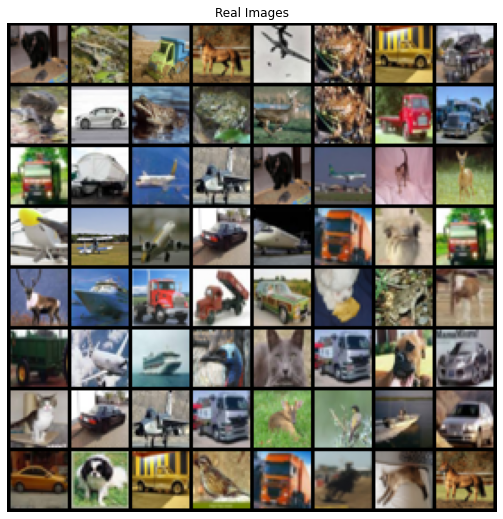

In [39]:
display_images(dataset.train_loader, max_idx=256)

In [40]:
from models.generator import Generator
Gen = Generator().to(device)
summary(Gen,(128,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]         131,072
         LeakyReLU-2                 [-1, 1024]               0
       BatchNorm1d-3                 [-1, 1024]           2,048
      PixelShuffle-4             [-1, 64, 4, 4]               0
            Conv2d-5            [-1, 256, 4, 4]         147,456
         LeakyReLU-6            [-1, 256, 4, 4]               0
       BatchNorm2d-7            [-1, 256, 4, 4]             512
      PixelShuffle-8             [-1, 64, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         147,456
        LeakyReLU-10            [-1, 256, 8, 8]               0
      BatchNorm2d-11            [-1, 256, 8, 8]             512
     PixelShuffle-12           [-1, 64, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         147,456
        LeakyReLU-14          [-1, 256,

In [41]:
# ViT Discriminator
from models.ViT_discriminator import Discriminator
from types import SimpleNamespace
args = SimpleNamespace(**{"d_depth": 7, "df_dim": 384, "img_size": 32, "patch_size": 8})
Dis = Discriminator(args).to(device)
summary(Dis,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 384, 4, 4]          74,112
           Dropout-2              [-1, 17, 384]               0
         LayerNorm-3              [-1, 17, 384]             768
            Linear-4             [-1, 17, 1152]         442,368
            matmul-5            [-1, 4, 17, 17]               0
           Dropout-6            [-1, 4, 17, 17]               0
            matmul-7            [-1, 4, 17, 96]               0
            Linear-8              [-1, 17, 384]         147,840
           Dropout-9              [-1, 17, 384]               0
        Attention-10              [-1, 17, 384]               0
         Identity-11              [-1, 17, 384]               0
        LayerNorm-12              [-1, 17, 384]             768
           Linear-13             [-1, 17, 1536]         591,360
          Dropout-14             [-1, 1

In [42]:
# Baseline Discriminator
from models.discriminator import Discriminator
Dis = Discriminator().to(device)
summary(Dis,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
         LeakyReLU-2           [-1, 16, 32, 32]               0
            Conv2d-3           [-1, 32, 16, 16]           8,192
         LeakyReLU-4           [-1, 32, 16, 16]               0
       BatchNorm2d-5           [-1, 32, 16, 16]              64
            Conv2d-6             [-1, 64, 8, 8]          32,768
         LeakyReLU-7             [-1, 64, 8, 8]               0
       BatchNorm2d-8             [-1, 64, 8, 8]             128
            Conv2d-9            [-1, 128, 4, 4]         131,072
        LeakyReLU-10            [-1, 128, 4, 4]               0
      BatchNorm2d-11            [-1, 128, 4, 4]             256
           Conv2d-12            [-1, 256, 1, 1]         524,288
           Linear-13                    [-1, 1]             256
Total params: 697,456
Trainable params:

In [43]:
loss_fn = nn.BCEWithLogitsLoss()
fixed_noise = torch.randn(64, 128, device=device)
real_label = 1.
fake_label = 0.
lr,beta1 = 3e-4, 0
optG = optim.AdamW(Gen.parameters(), lr=lr, betas=(beta1, 0.999))
optD = optim.AdamW(Dis.parameters(), lr=lr, betas=(beta1, 0.999))

In [44]:
img_list = []
G_losses = []
D_losses = []
iters = 0

# Number of training epochs
num_epochs = 50

In [45]:
for epoch in range(num_epochs):
    for i, data in enumerate(dataset.train_loader):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        Dis.zero_grad()
        # Format batch
        real = data[0].to(device)
        b_size = real.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = Dis(real).view(-1)
        # Calculate loss on all-real batch
        errD_real = loss_fn(output,label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = torch.sigmoid(output).mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, 128, 1,1, device=device)
        # Generate fake image batch with G
        fake = Gen(noise)
        label = torch.full_like(label, fake_label)
        # Classify all fake batch with D
        output = Dis(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = loss_fn(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = torch.sigmoid(output).mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        Gen.zero_grad()
        label = torch.full_like(label,real_label) # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = Dis(fake).view(-1)
        # Calculate G's loss based on this output
        errG = loss_fn(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = torch.sigmoid(output).mean().item()
        # Update G
        optG.step()

        # Output training stats
        if (i+1) %100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                % (epoch, num_epochs, i, len(dataset.train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataset.train_loader)-1)):
            with torch.no_grad():
                fake = Gen(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters +=1
             

KeyboardInterrupt: ignored

In [ ]:
_, axs = plt.subplots(1,2,figsize=(15,15))
display_images(dataset.train_loader,ax = axs[0], max_idx=256)
display_images(img_list, ax = axs[1], max_idx=256)
plt.tight_layout()

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Calculating FID Score

In [ ]:
from utils.torch_fid_score import get_fid

In [ ]:
stat_path = Path('fid_stats/cifar_10_valid_fid_stats.npz')
score = get_fid(Gen, 128, 10000, 256, stat_path)
print(f"\nFID score: {score}")

In [ ]:
rc('animation', html='jshtml')
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
ani